In [62]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from tqdm import tqdm
import time



In [63]:
#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


Function

In [64]:
def get_pn_df(df, grp):
    # group neg by grp
    df_neg = df.groupby([grp])['neg'].apply(list).reset_index()
    df_neg['mean'] = df_neg['neg'].apply(np.mean)
    df_neg['median'] = df_neg['neg'].apply(np.median)
    #display(df_neg)

    # group pos by user_location
    df_pos = df.groupby([grp])['pos'].apply(list).reset_index()
    df_pos['mean'] = df_pos['pos'].apply(np.mean)
    df_pos['median'] = df_pos['pos'].apply(np.median)
    #display(df_pos)

    
    return df_neg, df_pos

In [65]:
def set_map():
    # Load shapefiles
    world = gpd.read_file('../data/shapefiles/world-administrative-boundaries.zip')
    states = gpd.read_file('../data/shapefiles/georef-united-states-of-america-state-millesime.zip')
    uk = gpd.read_file('../data/shapefiles/infuse_ctry_2011_clipped.zip')

    # clean world
    world_clean = world[world['name'] != 'United States of America'][['name','geometry']]
    world_clean = world_clean[world_clean['name'] != 'U.K. of Great Britain and Northern Ireland'][['name','geometry']]
    #world_clean.name = world_clean.name.str.replace("U.K. of Great Britain and Northern Ireland", "England")

    # clean states
    states.ste_name = states.ste_name.str.replace("['", "")
    states.ste_name = states.ste_name.str.replace("']", "")
    states_clean = states[['ste_name','geometry']]
    states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)

    # clean uk
    uk_clean = uk[['geo_label','geometry']]
    uk_clean.rename({'geo_label':'name'}, inplace=True, axis=1)
    uk_clean = uk_clean.to_crs(world_clean.crs)
    #display(uk_clean)

    # concatenate
    shapefile = pd.concat([world_clean, states_clean, uk_clean], axis=0)

    # display the duplicates in shapefile['name]
    shapefile[shapefile.duplicated(subset=['name'], keep=False)].sort_values(by='name')

    # remove duplicates
    shapefile = shapefile.drop_duplicates(subset=['name'], keep='first')
    print("ducplicates :")
    display(shapefile[shapefile.duplicated(subset=['name'], keep=False)].sort_values(by='name'))
    print("shapefile names:")
    display(shapefile['name'])
    return shapefile

In [79]:
def plot_map(df, shapefile, title, set):
    sf_maincat = shapefile.copy()

    # in user_location remove the str 'United States of America'
    df['user_location'] = df['user_location'].str.replace("United States, ", "")

    if sum(df['user_location'].str.contains("Russian")) == 0:
        df['user_location'] = df['user_location'].str.replace("Russia", "Russian Federation")

    #df_neg['user_location'] = df_neg['user_location'].str.replace("Scottland", "England")
    #display(df_neg)

    #display all elements of the column user_location that aren't in the shapefile
    print("Elements of the column user_location that aren't in the shapefile :")
    display(df[~df['user_location'].isin(sf_maincat['name'])])


    # Merge the GeoDataFrame with the DataFrame containing data
    world_data = sf_maincat.merge(df, how='left', left_on='name', right_on='user_location')
    print("world_data :")
    display(world_data)
    
    # Plot the main predictor on a world map
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    #sf_maincat.boundary.plot(ax=ax, linewidth=.2, color='black')
    world_data.plot(column='median', ax=ax, legend=True, cmap='viridis')
    #sf_maincat.plot(column='main_cat', ax=ax, legend=True)
    plt.title(title + ' Country ' + 'in ' + set)
    plt.axis('off')
    plt.savefig('../results/'+title+'_'+set+'.png', dpi=300)
    plt.show()




In [67]:
def data_prep(df, grp):
    # sentiment analysis of the column text
    analyzer = SentimentIntensityAnalyzer()

    #only keep the interresting columns
    df_new = df[['beer_name', 'brewery_name', 'style', 'abv',  'overall', 'rating', 'text', 'user_location', 'brewery_location', 'nbr_beers_by_brewery', 'zscore']]


    #remove NaN values
    df_new = df_new.dropna()

    #remove duplicates
    df_new = df_new.drop_duplicates()

    #reset index
    df_new = df_new.reset_index(drop=True)



    # add the columns for the scores
    df_new['compound'] = ''
    df_new['neg'] = ''
    df_new['neu'] = ''
    df_new['pos'] = ''

    #select every 100th line
    df_new = df_new[::100]



    #loop through the rows and add the scores to the columns

    for index, row in tqdm(df_new.iterrows(), total=len(df_new)):
        scores = analyzer.polarity_scores(row['text'])
        df_new.at[index, 'compound'] = scores['compound']
        df_new.at[index, 'neg'] = scores['neg']
        df_new.at[index, 'neu'] = scores['neu']
        df_new.at[index, 'pos'] = scores['pos']

    #display(df_new)

    # find the user_location with the most appearences
    a = df_new[grp].value_counts()
    print("Most appearences :")
    display(a)

    #keep only the ones with more than 5 appearences
    a = a[a > 5]
    #display(a)

    #remove all the lines of df_short that are not in a
    df_new = df_new[df_new[grp].isin(a.index)]

    return df_new

    

In [68]:
shapefile = set_map()

C:\Users\ben\AppData\Local\Temp\ipykernel_18632\998899382.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)
C:\Users\ben\AppData\Local\Temp\ipykernel_18632\998899382.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_clean.rename({'geo_label':'name'}, inplace=True, axis=1)


ducplicates :


,name,geometry


shapefile :


0      Northern Mariana Islands
1                 Kuril Islands
2                        France
3                        Serbia
4                       Uruguay
                 ...           
142                     Montana
0              Northern Ireland
1                      Scotland
2                       England
3                         Wales
Name: name, Length: 309, dtype: object

Let us start with BeerAdvocate

In [69]:
df_ba = pd.read_pickle('../data/preprocessed/BeerAdvocate/transformed_ratings_ba.pkl')
df_rb = pd.read_pickle('../data/preprocessed/RateBeer/transformed_ratings_rb.pkl')
#display(df_ba)
#display(df_rb)

In [70]:
# select columns from df, do sentiment analysis, group the data by grp, keep only the ones with more than 5 appearences
df_work_ba = data_prep(df_ba, 'user_location')
df_work_rb = data_prep(df_rb, 'user_location')


100%|██████████| 25031/25031 [00:21<00:00, 1149.85it/s]

Most appearences :


user_location
United States, Pennsylvania     2081
United States, California       1951
United States, New York         1604
United States, Illinois         1329
United States, Massachusetts    1302
                                ... 
Czech Republic                     1
Vietnam                            1
American Samoa                     1
Trinidad and Tobago                1
Costa Rica                         1
Name: count, Length: 119, dtype: int64

100%|██████████| 67458/67458 [00:19<00:00, 3466.11it/s]


Most appearences :


user_location
Denmark                      5628
Canada                       5108
England                      4436
United States, California    2968
Sweden                       2810
                             ... 
Tunisia                         1
Afghanistan                     1
Bulgaria                        1
Algeria                         1
Uruguay                         1
Name: count, Length: 138, dtype: int64

In [71]:
df_neg_ba, df_pos_ba = get_pn_df(df_work_ba, 'user_location')
display(df_neg_ba)
display(df_pos_ba)
df_neg_rb, df_pos_rb = get_pn_df(df_work_rb, 'user_location')

,user_location,neg,mean,median
0,Australia,"[0.203, 0.015, 0.067, 0.064, 0.0, 0.04, 0.0, 0...",0.044697,0.0400
1,Austria,"[0.033, 0.0, 0.026, 0.047, 0.06, 0.039]",0.034167,0.0360
2,Belgium,"[0.075, 0.045, 0.085, 0.042, 0.086, 0.058, 0.0...",0.067800,0.0580
3,Brazil,"[0.086, 0.0, 0.041, 0.033, 0.061, 0.0, 0.044, ...",0.046600,0.0495
4,Canada,"[0.012, 0.018, 0.124, 0.042, 0.024, 0.036, 0.0...",0.040368,0.0330
...,...,...,...,...
73,"United States, Virginia","[0.039, 0.084, 0.031, 0.028, 0.045, 0.007, 0.0...",0.036343,0.0300
74,"United States, Washington","[0.139, 0.042, 0.021, 0.054, 0.06, 0.024, 0.04...",0.040295,0.0330
75,"United States, West Virginia","[0.0, 0.018, 0.009, 0.028, 0.03, 0.022, 0.0, 0...",0.032314,0.0250
76,"United States, Wisconsin","[0.0, 0.021, 0.064, 0.036, 0.042, 0.073, 0.1, ...",0.037564,0.0310


,user_location,pos,mean,median
0,Australia,"[0.066, 0.252, 0.101, 0.217, 0.232, 0.095, 0.0...",0.149307,0.1500
1,Austria,"[0.206, 0.14, 0.18, 0.09, 0.0, 0.148]",0.127333,0.1440
2,Belgium,"[0.18, 0.162, 0.139, 0.304, 0.256, 0.166, 0.04...",0.162244,0.1540
3,Brazil,"[0.087, 0.42, 0.104, 0.224, 0.15, 0.025, 0.118...",0.160900,0.1240
4,Canada,"[0.05, 0.106, 0.023, 0.204, 0.128, 0.201, 0.10...",0.151963,0.1460
...,...,...,...,...
73,"United States, Virginia","[0.265, 0.195, 0.273, 0.143, 0.2, 0.143, 0.209...",0.167706,0.1600
74,"United States, Washington","[0.098, 0.18, 0.317, 0.265, 0.124, 0.338, 0.18...",0.161618,0.1530
75,"United States, West Virginia","[0.085, 0.14, 0.101, 0.173, 0.253, 0.175, 0.12...",0.146895,0.1400
76,"United States, Wisconsin","[0.088, 0.196, 0.149, 0.108, 0.116, 0.241, 0.1...",0.157824,0.1515


Elements of the column user_location that aren't in the shapefile :


,user_location,neg,mean,median


world_data :


,name,geometry,user_location,neg,mean,median
0,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...",NaN,NaN,NaN,NaN
1,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ...",NaN,NaN,NaN,NaN
2,France,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6...",France,"[0.0, 0.057, 0.0, 0.097, 0.026, 0.043, 0.0, 0....",0.034816,0.0280
3,Serbia,"POLYGON ((20.26102 46.11485, 20.31403 46.06986...",NaN,NaN,NaN,NaN
4,Uruguay,"POLYGON ((-53.37430 -33.74067, -53.39917 -33.7...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
304,Montana,"POLYGON ((-111.05243 44.47841, -111.05578 44.4...",Montana,"[0.0, 0.036, 0.021, 0.08, 0.017, 0.023, 0.162,...",0.043120,0.0340
305,Northern Ireland,"MULTIPOLYGON (((-5.44132 54.47733, -5.44124 54...",Northern Ireland,"[0.024, 0.032, 0.056, 0.072, 0.042, 0.0, 0.046...",0.038045,0.0320
306,Scotland,"MULTIPOLYGON (((-3.76436 58.57616, -3.76404 58...",Scotland,"[0.053, 0.0, 0.022, 0.0, 0.055, 0.171, 0.014, ...",0.050614,0.0365
307,England,"MULTIPOLYGON (((-4.90358 50.21068, -4.90358 50...",England,"[0.033, 0.0, 0.053, 0.106, 0.042, 0.15, 0.04, ...",0.050676,0.0420


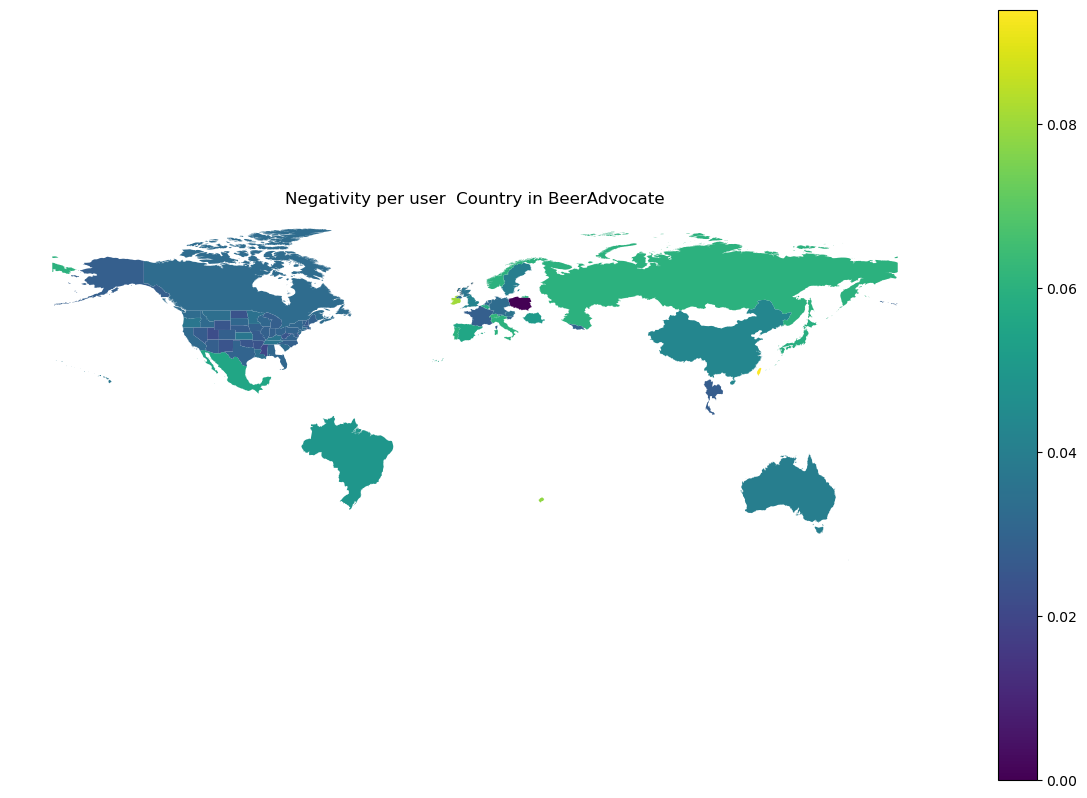

Elements of the column user_location that aren't in the shapefile :


,user_location,neg,mean,median
0,Ascension Island,"[0.0, 0.136, 0.045, 0.122, 0.033, 0.0]",0.056000,0.039
38,Moldova,"[0.055, 0.087, 0.049, 0.097, 0.161, 0.0, 0.111...",0.059281,0.049
51,Slovak Republic,"[0.0, 0.0, 0.085, 0.257, 0.158, 0.091, 0.07, 0...",0.063572,0.059


world_data :


,name,geometry,user_location,neg,mean,median
0,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...",NaN,NaN,NaN,NaN
1,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ...",NaN,NaN,NaN,NaN
2,France,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6...",France,"[0.0, 0.103, 0.036, 0.097, 0.0, 0.019, 0.0, 0....",0.044335,0.0255
3,Serbia,"POLYGON ((20.26102 46.11485, 20.31403 46.06986...",Serbia,"[0.1, 0.052, 0.039, 0.132, 0.048, 0.0, 0.0, 0....",0.058625,0.0500
4,Uruguay,"POLYGON ((-53.37430 -33.74067, -53.39917 -33.7...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
304,Montana,"POLYGON ((-111.05243 44.47841, -111.05578 44.4...",Montana,"[0.0, 0.138, 0.101, 0.099, 0.044, 0.027, 0.0, ...",0.037604,0.0000
305,Northern Ireland,"MULTIPOLYGON (((-5.44132 54.47733, -5.44124 54...",Northern Ireland,"[0.066, 0.028, 0.105, 0.0, 0.14, 0.258, 0.0, 0...",0.063455,0.0610
306,Scotland,"MULTIPOLYGON (((-3.76436 58.57616, -3.76404 58...",Scotland,"[0.0, 0.0, 0.0, 0.177, 0.058, 0.072, 0.144, 0....",0.048469,0.0200
307,England,"MULTIPOLYGON (((-4.90358 50.21068, -4.90358 50...",England,"[0.0, 0.0, 0.048, 0.034, 0.043, 0.04, 0.0, 0.1...",0.053028,0.0420


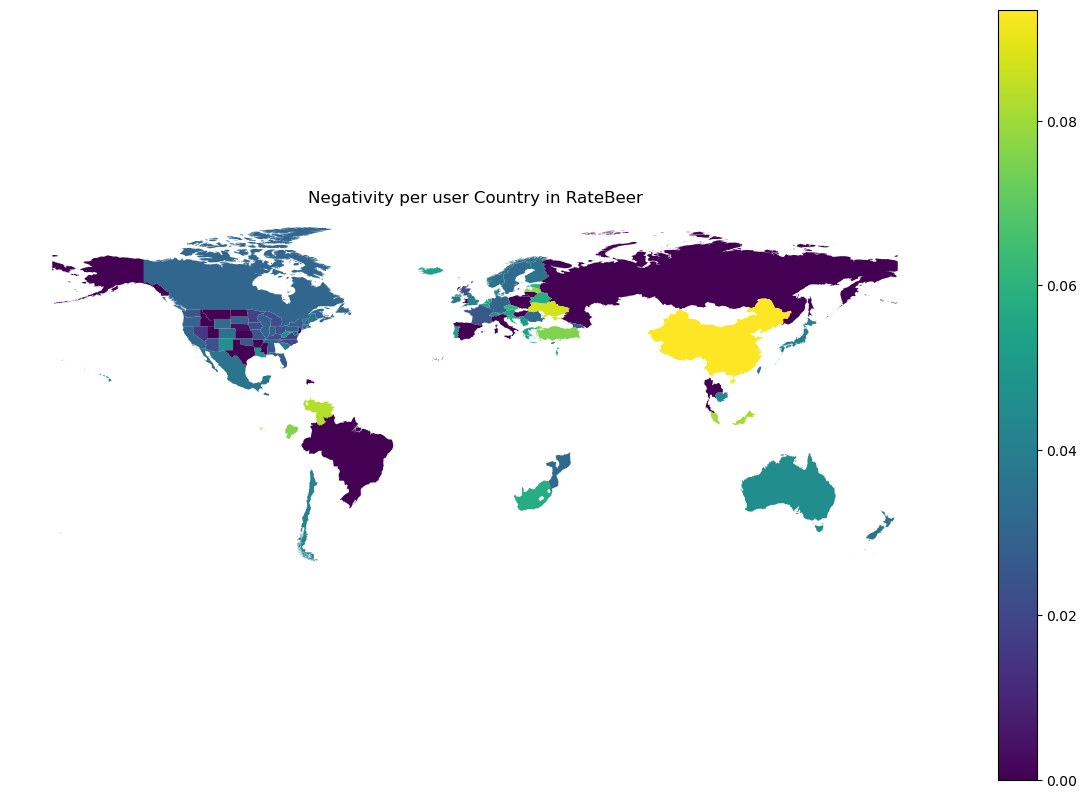

In [80]:
plot_map(df_neg_ba, shapefile, "Negativity per user ", "BeerAdvocate")
plot_map(df_neg_rb, shapefile, "Negativity per user", "RateBeer")

Elements of the column user_location that aren't in the shapefile :


,user_location,pos,mean,median


world_data :


,name,geometry,user_location,pos,mean,median
0,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...",NaN,NaN,NaN,NaN
1,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ...",NaN,NaN,NaN,NaN
2,France,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6...",France,"[0.111, 0.183, 0.191, 0.222, 0.283, 0.268, 0.1...",0.127789,0.1290
3,Serbia,"POLYGON ((20.26102 46.11485, 20.31403 46.06986...",NaN,NaN,NaN,NaN
4,Uruguay,"POLYGON ((-53.37430 -33.74067, -53.39917 -33.7...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
304,Montana,"POLYGON ((-111.05243 44.47841, -111.05578 44.4...",Montana,"[0.17, 0.169, 0.144, 0.103, 0.057, 0.235, 0.18...",0.132880,0.1440
305,Northern Ireland,"MULTIPOLYGON (((-5.44132 54.47733, -5.44124 54...",Northern Ireland,"[0.191, 0.141, 0.153, 0.06, 0.163, 0.319, 0.21...",0.182545,0.1890
306,Scotland,"MULTIPOLYGON (((-3.76436 58.57616, -3.76404 58...",Scotland,"[0.069, 0.179, 0.177, 0.18, 0.153, 0.199, 0.25...",0.161977,0.1565
307,England,"MULTIPOLYGON (((-4.90358 50.21068, -4.90358 50...",England,"[0.12, 0.181, 0.176, 0.112, 0.262, 0.261, 0.13...",0.138039,0.1320


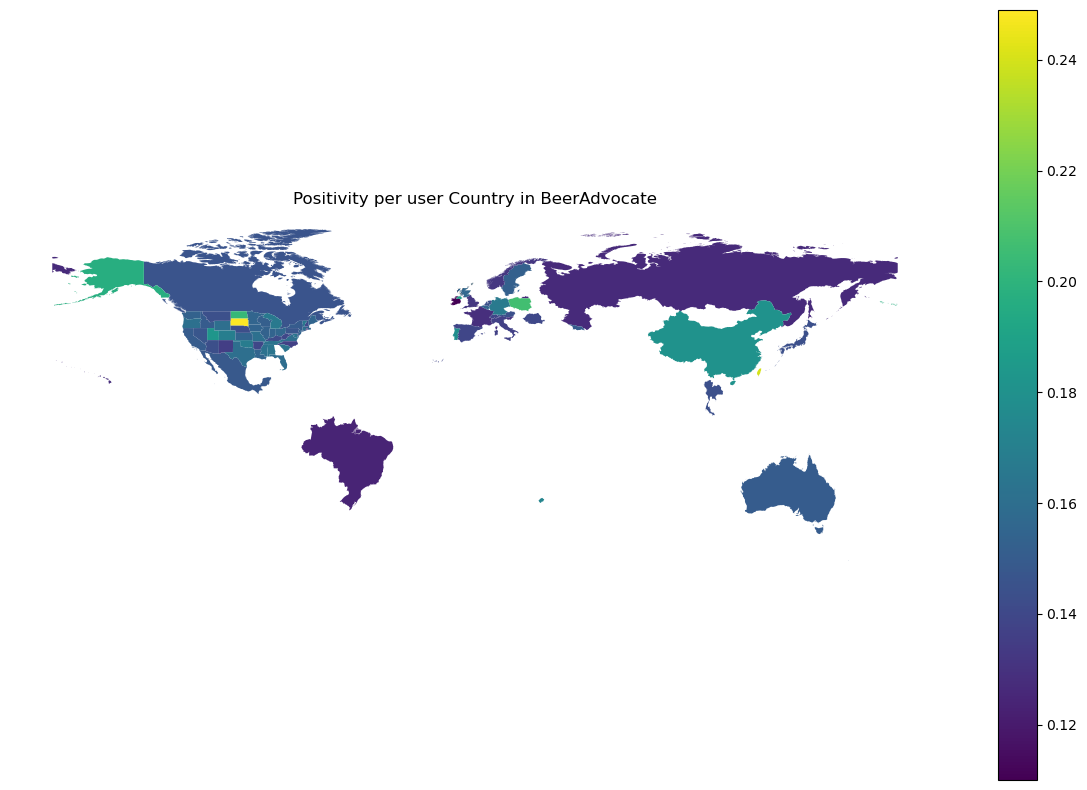

Elements of the column user_location that aren't in the shapefile :


,user_location,pos,mean,median
0,Ascension Island,"[0.104, 0.185, 0.095, 0.226, 0.26, 0.04]",0.151667,0.1445
38,Moldova,"[0.121, 0.159, 0.212, 0.244, 0.07, 0.262, 0.14...",0.184456,0.1850
51,Slovak Republic,"[0.288, 0.316, 0.251, 0.0, 0.082, 0.124, 0.182...",0.151662,0.1540


world_data :


,name,geometry,user_location,pos,mean,median
0,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...",NaN,NaN,NaN,NaN
1,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ...",NaN,NaN,NaN,NaN
2,France,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6...",France,"[0.0, 0.29, 0.0, 0.0, 0.077, 0.038, 0.0, 0.298...",0.097884,0.0640
3,Serbia,"POLYGON ((20.26102 46.11485, 20.31403 46.06986...",Serbia,"[0.179, 0.235, 0.199, 0.0, 0.2, 0.19, 0.0, 0.0...",0.117531,0.1205
4,Uruguay,"POLYGON ((-53.37430 -33.74067, -53.39917 -33.7...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
304,Montana,"POLYGON ((-111.05243 44.47841, -111.05578 44.4...",Montana,"[0.185, 0.151, 0.249, 0.175, 0.21, 0.124, 0.20...",0.151563,0.1510
305,Northern Ireland,"MULTIPOLYGON (((-5.44132 54.47733, -5.44124 54...",Northern Ireland,"[0.218, 0.146, 0.0, 0.0, 0.209, 0.109, 0.329, ...",0.141977,0.1350
306,Scotland,"MULTIPOLYGON (((-3.76436 58.57616, -3.76404 58...",Scotland,"[0.281, 0.0, 0.17, 0.19, 0.188, 0.039, 0.134, ...",0.135164,0.1300
307,England,"MULTIPOLYGON (((-4.90358 50.21068, -4.90358 50...",England,"[0.138, 0.236, 0.242, 0.223, 0.083, 0.203, 0.0...",0.141562,0.1320


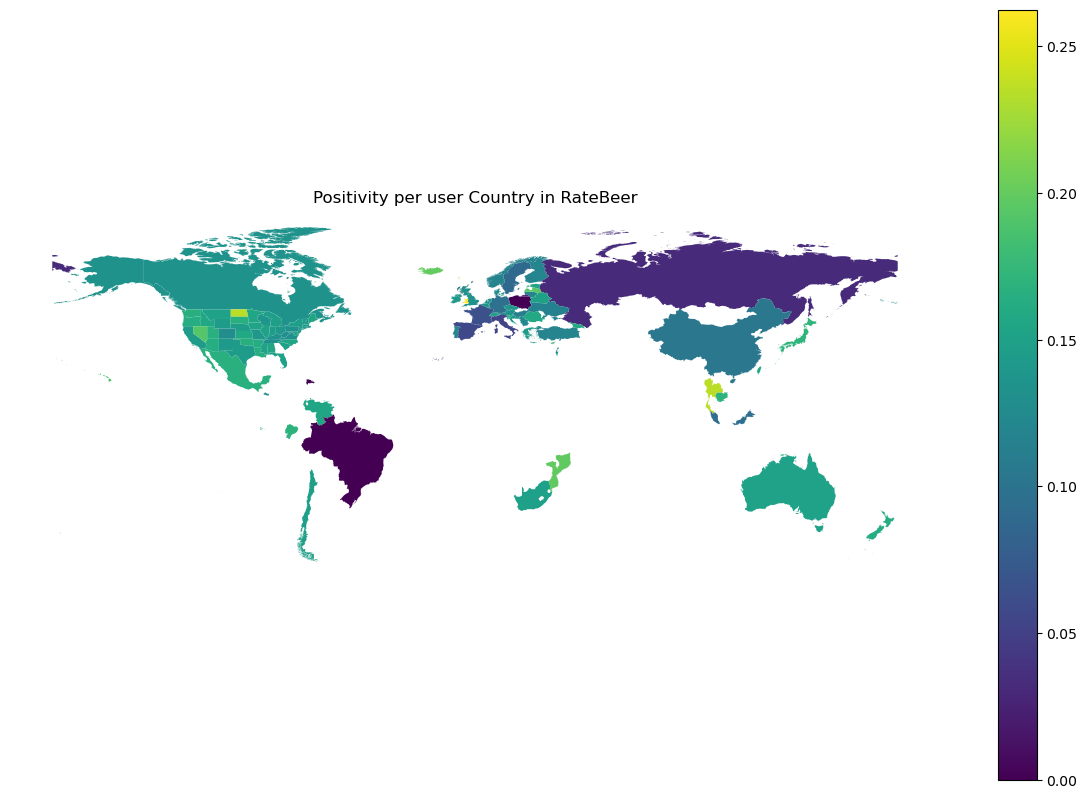

In [81]:
plot_map(df_pos_ba, shapefile, "Positivity per user", "BeerAdvocate")
plot_map(df_pos_rb, shapefile, "Positivity per user", "RateBeer")

Data treatment now in functions

In [6]:
# sentiment analysis of the column text

#start with first element
analyzer = SentimentIntensityAnalyzer()
scores = analyzer.polarity_scores(df_ba['text'][0])
print(scores)

#only keep the interresting columns
df_ba_new = df_ba[['beer_name', 'brewery_name', 'style', 'abv',  'overall', 'rating', 'text', 'user_location', 'brewery_location', 'nbr_beers_by_brewery', 'zscore']]


#remove NaN values
df_ba_new = df_ba_new.dropna()

#remove duplicates
df_ba_new = df_ba_new.drop_duplicates()

#reset index
df_ba_new = df_ba_new.reset_index(drop=True)



# add the columns for the scores
df_ba_new['compound'] = ''
df_ba_new['neg'] = ''
df_ba_new['neu'] = ''
df_ba_new['pos'] = ''

#select every 100th line
df_ba_new = df_ba_new[::100]


{'neg': 0.139, 'neu': 0.763, 'pos': 0.098, 'compound': -0.4312}


In [7]:
from tqdm import tqdm
import time

#loop through the rows and add the scores to the columns

for index, row in tqdm(df_ba_new.iterrows(), total=len(df_ba_new)):
    scores = analyzer.polarity_scores(row['text'])
    df_ba_new.at[index, 'compound'] = scores['compound']
    df_ba_new.at[index, 'neg'] = scores['neg']
    df_ba_new.at[index, 'neu'] = scores['neu']
    df_ba_new.at[index, 'pos'] = scores['pos']

display(df_ba_new)


100%|██████████| 25031/25031 [00:21<00:00, 1143.63it/s]


,beer_name,brewery_name,style,abv,overall,rating,text,user_location,brewery_location,nbr_beers_by_brewery,zscore,compound,neg,neu,pos
0,Régab,Societe des Brasseries du Gabon (SOBRAGA),Euro Pale Lager,4.5,3.00,23.887872,"From a bottle, pours a piss yellow color with ...","United States, Washington",Gabon,1,-1.535859,-0.4312,0.139,0.763,0.098
100,St. Patrick's Best,Strangford Lough Brewing Company Ltd,English Bitter,4.2,4.00,46.656000,"Pours a clear, amber color. 1/4 inch head of a...","United States, Missouri",Northern Ireland,5,-0.638129,0.813,0.039,0.803,0.158
200,Caffrey's Irish Ale,Thomas Caffrey Brewing Co.,Irish Red Ale,3.8,3.50,47.832147,Poured a promising amber with a luxurious nitr...,"United States, California",Northern Ireland,2,-0.591755,0.85,0.064,0.832,0.103
300,McGrath's Irish Red,Clanconnel Brewing Company,Irish Red Ale,4.3,3.75,53.582633,Appearance - Dark amber red with a think head ...,Northern Ireland,Northern Ireland,6,-0.365018,0.9857,0.024,0.785,0.191
400,Bleddyn 1075,The Celt Experience,English India Pale Ale (IPA),5.6,4.25,68.921000,"Pleasantly cloudy body, capped with an outstan...","United States, New York",Wales,35,0.239762,0.9559,0.0,0.64,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2502600,Michigan Brewing Peninsula Porter,Michigan Brewing Company,American Porter,5.5,4.00,64.000000,"A dark brown but completely clear brew, shines...","United States, Minnesota","United States, Michigan",56,0.045731,0.9739,0.025,0.612,0.363
2502700,Michigan Brewing Sunset Amber,Michigan Brewing Company,Vienna Lager,5.0,3.50,34.328125,This beer was poured into a pint glass. It had...,"United States, Michigan","United States, Michigan",56,-1.124208,0.7783,0.0,0.9,0.1
2502800,Michigan Brewing Wheatland,Michigan Brewing Company,Hefeweizen,5.0,3.50,56.623104,Went to Webberville today to try some brews! A...,"United States, Michigan","United States, Michigan",56,-0.245134,0.1697,0.113,0.767,0.121
2502900,Chaotic Double IPA,Twisted Manzanita Ales,American Double / Imperial IPA,10.1,3.75,47.045881,Poured into a sam adams custom glass: color is...,"United States, Pennsylvania","United States, California",45,-0.622757,0.9465,0.045,0.801,0.154


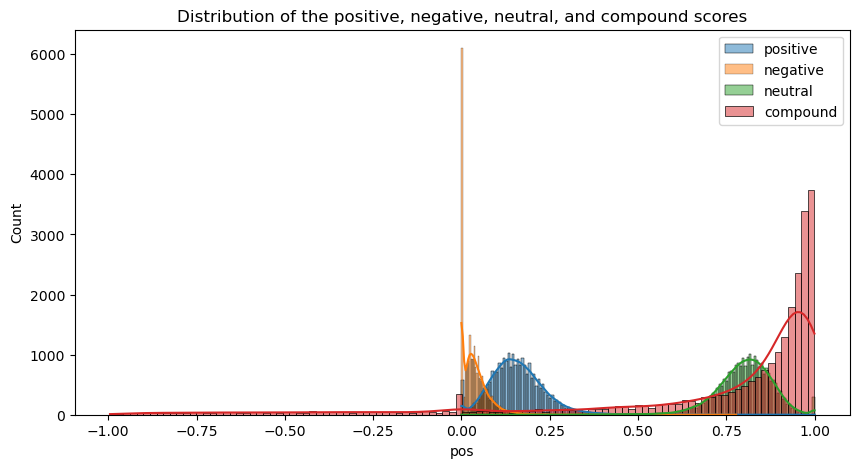

In [8]:
# plot the distribution of the positive, negative, neutral, and compound scores
plt.figure(figsize=(10, 5))
plt.title('Distribution of the positive, negative, neutral, and compound scores')

sns.histplot(data=df_ba_new, x='pos', label='positive', kde=True)
sns.histplot(data=df_ba_new, x='neg', label='negative', kde=True)
sns.histplot(data=df_ba_new, x='neu', label='neutral', kde=True)
sns.histplot(data=df_ba_new, x='compound', label='compound', kde=True)

plt.legend()
plt.show()



In [9]:
b_rev = 'this is the worst beer I have ever tasted'
g_rev = 'this is the best beer I have ever tasted'
print(analyzer.polarity_scores(b_rev))
print(analyzer.polarity_scores(g_rev))


{'neg': 0.339, 'neu': 0.661, 'pos': 0.0, 'compound': -0.6249}
{'neg': 0.0, 'neu': 0.656, 'pos': 0.344, 'compound': 0.6369}


In [ ]:
# find the user_location with the most appearences
a = df_ba_new['user_location'].value_counts()
display(a)

#keep only the ones with more than 5 appearences
a = a[a > 5]
#display(a)

#remove all the lines of df_short that are not in a
df_ba_new = df_ba_new[df_ba_new['user_location'].isin(a.index)]

In [10]:
# group neg by user_location
df_neg = df_ba_new.groupby(['user_location'])['neg'].apply(list).reset_index()
#df_neg = df_neg.sort_values(by='neg', ascending=False)
#display(df_neg)
#change list to array
#df_neg['neg'] = df_neg['neg'].apply(np.array)
#calculate the mean of the arrays
df_neg['mean'] = df_neg['neg'].apply(np.mean)
df_neg['median'] = df_neg['neg'].apply(np.median)
display(df_neg)

# group pos by user_location
df_pos = df_ba_new.groupby(['user_location'])['pos'].apply(list).reset_index()
#df_pos = df_pos.sort_values(by='pos', ascending=False)
#display(df_pos)
#df_pos['pos'] = df_pos['pos'].apply(np.array)
#calculate the mean of the arrays
df_pos['mean'] = df_pos['pos'].apply(np.mean)
df_pos['median'] = df_pos['pos'].apply(np.median)
display(df_pos)

#group neu by user_location
df_neu = df_ba_new.groupby(['user_location'])['neu'].apply(list).reset_index()
#df_neu = df_neu.sort_values(by='neu', ascending=False)
#display(df_neu)


#order df_neg by mean
#df_neg = df_neg.sort_values(by='mean', ascending=False)
#display(df_neg)
df_neg = df_neg.sort_values(by='median', ascending=False)
display(df_neg)

# only keep the columns user_location and median (better than mean cause influence of outliers ex: Taiwan)
df_neg = df_neg[['user_location', 'median']]
df_pos = df_pos[['user_location', 'median']]







user_location
United States, Pennsylvania     2081
United States, California       1951
United States, New York         1604
United States, Illinois         1329
United States, Massachusetts    1302
                                ... 
Czech Republic                     1
Vietnam                            1
American Samoa                     1
Trinidad and Tobago                1
Costa Rica                         1
Name: count, Length: 119, dtype: int64

,user_location,neg,mean,median
0,Australia,"[0.203, 0.015, 0.067, 0.064, 0.0, 0.04, 0.0, 0...",0.044697,0.0400
1,Austria,"[0.033, 0.0, 0.026, 0.047, 0.06, 0.039]",0.034167,0.0360
2,Belgium,"[0.075, 0.045, 0.085, 0.042, 0.086, 0.058, 0.0...",0.067800,0.0580
3,Brazil,"[0.086, 0.0, 0.041, 0.033, 0.061, 0.0, 0.044, ...",0.046600,0.0495
4,Canada,"[0.012, 0.018, 0.124, 0.042, 0.024, 0.036, 0.0...",0.040368,0.0330
...,...,...,...,...
73,"United States, Virginia","[0.039, 0.084, 0.031, 0.028, 0.045, 0.007, 0.0...",0.036343,0.0300
74,"United States, Washington","[0.139, 0.042, 0.021, 0.054, 0.06, 0.024, 0.04...",0.040295,0.0330
75,"United States, West Virginia","[0.0, 0.018, 0.009, 0.028, 0.03, 0.022, 0.0, 0...",0.032314,0.0250
76,"United States, Wisconsin","[0.0, 0.021, 0.064, 0.036, 0.042, 0.073, 0.1, ...",0.037564,0.0310


,user_location,pos,mean,median
0,Australia,"[0.066, 0.252, 0.101, 0.217, 0.232, 0.095, 0.0...",0.149307,0.1500
1,Austria,"[0.206, 0.14, 0.18, 0.09, 0.0, 0.148]",0.127333,0.1440
2,Belgium,"[0.18, 0.162, 0.139, 0.304, 0.256, 0.166, 0.04...",0.162244,0.1540
3,Brazil,"[0.087, 0.42, 0.104, 0.224, 0.15, 0.025, 0.118...",0.160900,0.1240
4,Canada,"[0.05, 0.106, 0.023, 0.204, 0.128, 0.201, 0.10...",0.151963,0.1460
...,...,...,...,...
73,"United States, Virginia","[0.265, 0.195, 0.273, 0.143, 0.2, 0.143, 0.209...",0.167706,0.1600
74,"United States, Washington","[0.098, 0.18, 0.317, 0.265, 0.124, 0.338, 0.18...",0.161618,0.1530
75,"United States, West Virginia","[0.085, 0.14, 0.101, 0.173, 0.253, 0.175, 0.12...",0.146895,0.1400
76,"United States, Wisconsin","[0.088, 0.196, 0.149, 0.108, 0.116, 0.241, 0.1...",0.157824,0.1515


,user_location,neg,mean,median
26,Taiwan,"[0.29, 0.029, 0.139, 0.028, 0.076, 0.095, 0.094]",0.107286,0.0940
9,Ireland,"[0.182, 0.068, 0.094, 0.091, 0.154, 0.0, 0.026...",0.079100,0.0805
12,Lesotho,"[0.02, 0.189, 0.078, 0.079, 0.034, 0.089, 0.04...",0.078000,0.0785
25,Switzerland,"[0.135, 0.062, 0.017, 0.193, 0.0, 0.0, 0.099, ...",0.063867,0.0620
16,Norway,"[0.065, 0.077, 0.037, 0.094, 0.0, 0.0, 0.0, 0....",0.054381,0.0600
...,...,...,...,...
31,"United States, Arkansas","[0.017, 0.061, 0.023, 0.139, 0.077, 0.02, 0.06...",0.030708,0.0240
35,"United States, Delaware","[0.063, 0.0, 0.0, 0.0, 0.0, 0.036, 0.024, 0.03...",0.037246,0.0240
71,"United States, Utah","[0.019, 0.0, 0.022, 0.0, 0.056, 0.056, 0.069, ...",0.028632,0.0220
51,"United States, Mississippi","[0.0, 0.0, 0.041, 0.034, 0.0, 0.021, 0.0, 0.0,...",0.028123,0.0200


Show results

In [19]:
# Load shapefiles
world = gpd.read_file('../data/shapefiles/world-administrative-boundaries.zip')
states = gpd.read_file('../data/shapefiles/georef-united-states-of-america-state-millesime.zip')
uk = gpd.read_file('../data/shapefiles/infuse_ctry_2011_clipped.zip')

# clean world
world_clean = world[world['name'] != 'United States of America'][['name','geometry']]
world_clean = world_clean[world_clean['name'] != 'U.K. of Great Britain and Northern Ireland'][['name','geometry']]
#world_clean.name = world_clean.name.str.replace("U.K. of Great Britain and Northern Ireland", "England")

# clean states
states.ste_name = states.ste_name.str.replace("['", "")
states.ste_name = states.ste_name.str.replace("']", "")
states_clean = states[['ste_name','geometry']]
states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)

# clean uk
uk_clean = uk[['geo_label','geometry']]
uk_clean.rename({'geo_label':'name'}, inplace=True, axis=1)
uk_clean = uk_clean.to_crs(world_clean.crs)
display(uk_clean)

# concatenate
shapefile = pd.concat([world_clean, states_clean, uk_clean], axis=0)

# check for duplicates
#display(shapefile[shapefile.duplicated(subset=['name'])])

# display the duplicates in shapefile['name]
shapefile[shapefile.duplicated(subset=['name'], keep=False)].sort_values(by='name')

# remove duplicates
shapefile = shapefile.drop_duplicates(subset=['name'], keep='first')
display(shapefile[shapefile.duplicated(subset=['name'], keep=False)].sort_values(by='name'))
display(shapefile['name'])


C:\Users\ben\AppData\Local\Temp\ipykernel_18632\549627609.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)
C:\Users\ben\AppData\Local\Temp\ipykernel_18632\549627609.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uk_clean.rename({'geo_label':'name'}, inplace=True, axis=1)


,name,geometry
0,Northern Ireland,"MULTIPOLYGON (((-5.44132 54.47733, -5.44124 54..."
1,Scotland,"MULTIPOLYGON (((-3.76436 58.57616, -3.76404 58..."
2,England,"MULTIPOLYGON (((-4.90358 50.21068, -4.90358 50..."
3,Wales,"MULTIPOLYGON (((-4.61126 52.92351, -4.61126 52..."


In [30]:
# display the duplicates in shapefile['name]
shapefile[shapefile.duplicated(subset=['name'], keep=False)].sort_values(by='name')

# remove duplicates
shapefile = shapefile.drop_duplicates(subset=['name'], keep='first')
display(shapefile[shapefile.duplicated(subset=['name'], keep=False)].sort_values(by='name'))
display(shapefile['name'])

,name,geometry


0      Northern Mariana Islands
1                 Kuril Islands
2                        France
3                        Serbia
4                       Uruguay
                 ...           
142                     Montana
0              Northern Ireland
1                      Scotland
2                       England
3                         Wales
Name: name, Length: 309, dtype: object

,user_location,median
26,Taiwan,0.0940
9,Ireland,0.0805
12,Lesotho,0.0785
25,Switzerland,0.0620
16,Norway,0.0600
...,...,...
31,Arkansas,0.0240
35,Delaware,0.0240
71,Utah,0.0220
51,Mississippi,0.0200


,user_location,median


,name,geometry,user_location,median
0,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...",NaN,NaN
1,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ...",NaN,NaN
2,France,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6...",France,0.0280
3,Serbia,"POLYGON ((20.26102 46.11485, 20.31403 46.06986...",NaN,NaN
4,Uruguay,"POLYGON ((-53.37430 -33.74067, -53.39917 -33.7...",NaN,NaN
...,...,...,...,...
421,Pennsylvania,"POLYGON ((-79.47666 39.72108, -79.49976 39.721...",Pennsylvania,0.0300
422,Northern Ireland,"MULTIPOLYGON (((-5.44132 54.47733, -5.44124 54...",Northern Ireland,0.0320
423,Scotland,"MULTIPOLYGON (((-3.76436 58.57616, -3.76404 58...",Scotland,0.0365
424,England,"MULTIPOLYGON (((-4.90358 50.21068, -4.90358 50...",England,0.0420


<Axes: >

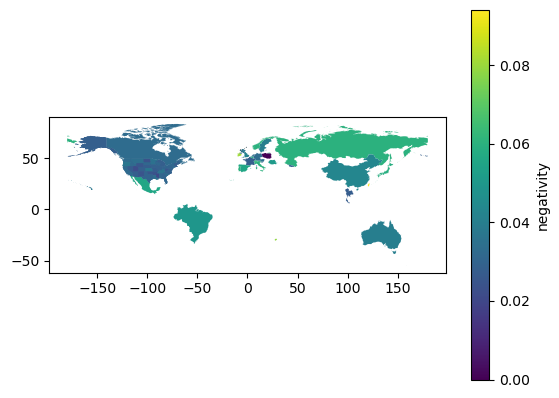

In [13]:
sf_maincat = shapefile.copy()

# in user_location remove the str 'United States of America'
df_neg['user_location'] = df_neg['user_location'].str.replace("United States, ", "")
df_neg['user_location'] = df_neg['user_location'].str.replace("Russia", "Russian Federation")
#df_neg['user_location'] = df_neg['user_location'].str.replace("Scottland", "England")
display(df_neg)

#display all elements of the column user_location that aren't in the shapefile
display(df_neg[~df_neg['user_location'].isin(sf_maincat['name'])])


# Merge the GeoDataFrame with the DataFrame containing data
world_data = sf_maincat.merge(df_neg, how='left', left_on='name', right_on='user_location')
display(world_data)


# Plotting the map
world_data.plot(column='median', legend=True, legend_kwds={'label': "negativity"})



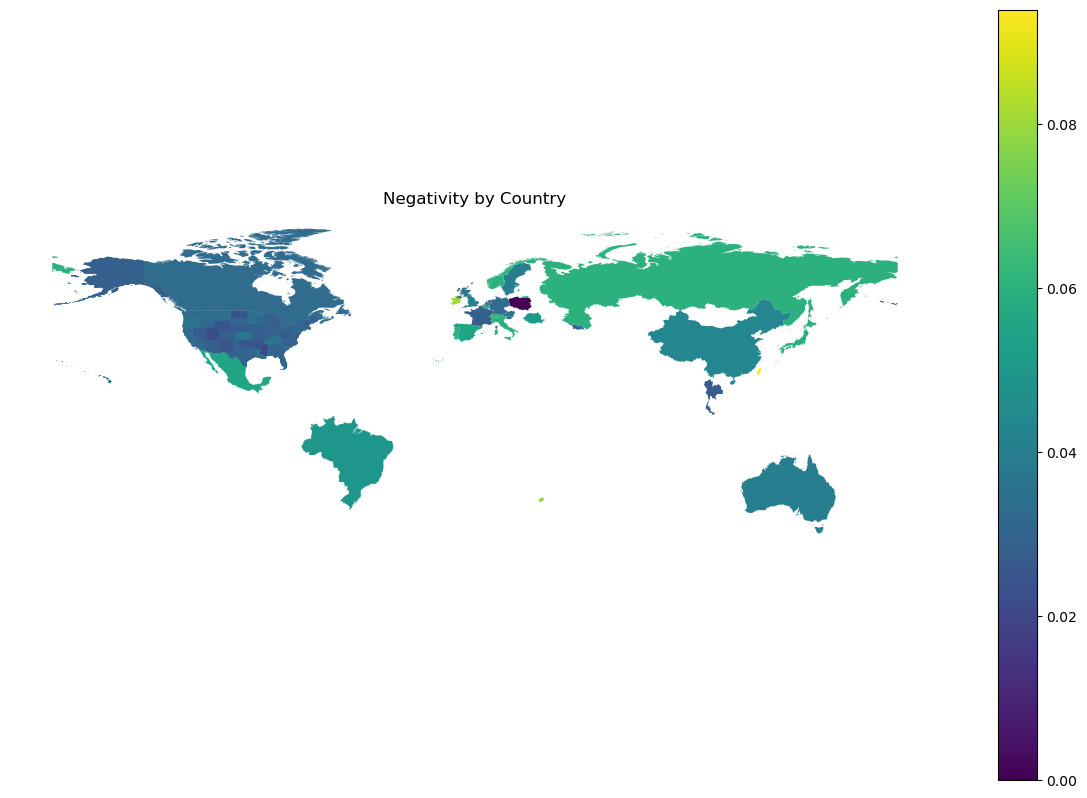

In [14]:
import matplotlib.colors as colors

# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
#sf_maincat.boundary.plot(ax=ax, linewidth=.2, color='black')
world_data.plot(column='median', ax=ax, legend=True, cmap='viridis')
#sf_maincat.plot(column='main_cat', ax=ax, legend=True)
plt.title('Negativity by Country')
plt.axis('off')
#plt.savefig('../results/map_pref_cat.png')
plt.show()

In [15]:
sf_maincat = shapefile.copy()

# in user_location remove the str 'United States of America'
df_pos['user_location'] = df_pos['user_location'].str.replace("United States, ", "")
df_pos['user_location'] = df_pos['user_location'].str.replace("Russia", "Russian Federation")
#df_neg['user_location'] = df_neg['user_location'].str.replace("Scottland", "England")
display(df_pos)

#display all elements of the column user_location that aren't in the shapefile
display(df_pos[~df_pos['user_location'].isin(sf_maincat['name'])])


# Merge the GeoDataFrame with the DataFrame containing data
world_data = sf_maincat.merge(df_pos, how='left', left_on='name', right_on='user_location')
display(world_data)


# Plotting the map
#world_data.plot(column='median', legend=True, legend_kwds={'label': "negativity"})



,user_location,median
0,Australia,0.1500
1,Austria,0.1440
2,Belgium,0.1540
3,Brazil,0.1240
4,Canada,0.1460
...,...,...
73,Virginia,0.1600
74,Washington,0.1530
75,West Virginia,0.1400
76,Wisconsin,0.1515


,user_location,median


,name,geometry,user_location,median
0,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ...",NaN,NaN
1,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ...",NaN,NaN
2,France,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6...",France,0.1290
3,Serbia,"POLYGON ((20.26102 46.11485, 20.31403 46.06986...",NaN,NaN
4,Uruguay,"POLYGON ((-53.37430 -33.74067, -53.39917 -33.7...",NaN,NaN
...,...,...,...,...
421,Pennsylvania,"POLYGON ((-79.47666 39.72108, -79.49976 39.721...",Pennsylvania,0.1470
422,Northern Ireland,"MULTIPOLYGON (((-5.44132 54.47733, -5.44124 54...",Northern Ireland,0.1890
423,Scotland,"MULTIPOLYGON (((-3.76436 58.57616, -3.76404 58...",Scotland,0.1565
424,England,"MULTIPOLYGON (((-4.90358 50.21068, -4.90358 50...",England,0.1320


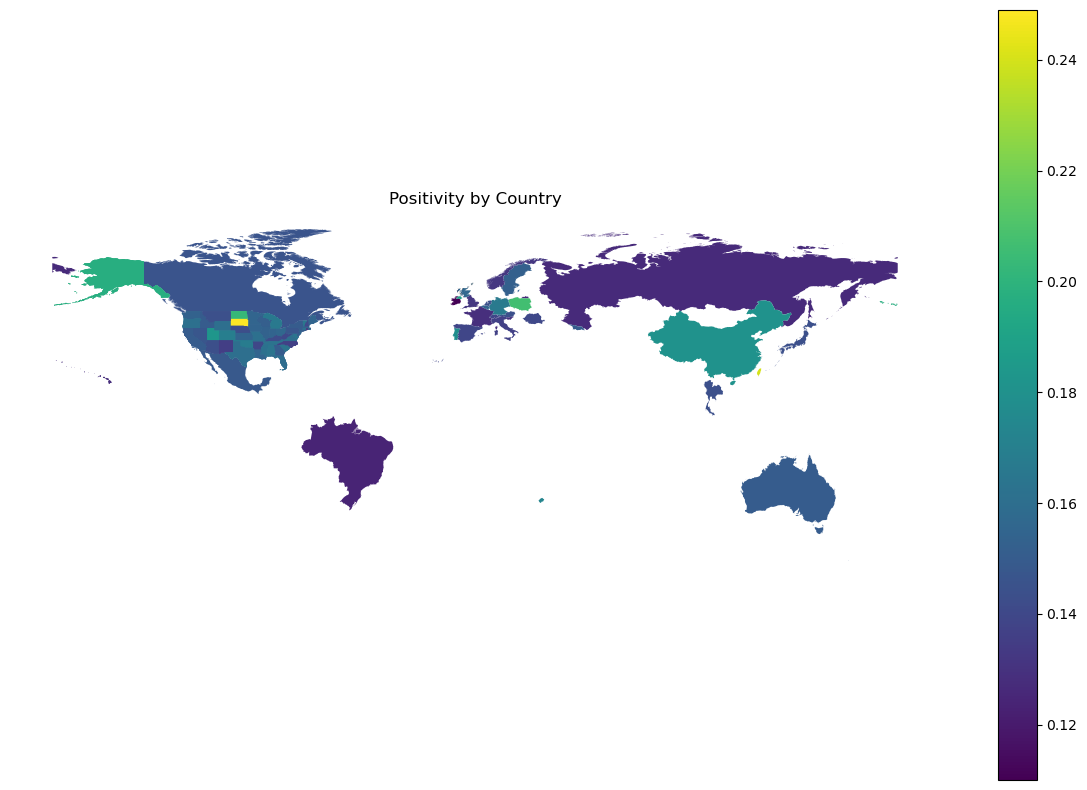

In [16]:
# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
#sf_maincat.boundary.plot(ax=ax, linewidth=.2, color='black')
world_data.plot(column='median', ax=ax, legend=True, cmap='viridis')
#sf_maincat.plot(column='main_cat', ax=ax, legend=True)
plt.title('Positivity by Country')
plt.axis('off')
#plt.savefig('../results/map_pref_cat.png')
plt.show()

Now let us check by production

In [17]:
# group neg by user_location
br_neg = df_ba_new.groupby(['brewery_location'])['neg'].apply(list).reset_index()

br_neg['mean'] = br_neg['neg'].apply(np.mean)
br_neg['median'] = br_neg['neg'].apply(np.median)
display(br_neg)

,brewery_location,neg,mean,median
0,Argentina,"[0.076, 0.039, 0.0, 0.015, 0.036]",0.033200,0.036
1,Armenia,[0.021],0.021000,0.021
2,Australia,"[0.081, 0.118, 0.04, 0.047, 0.0, 0.049, 0.036,...",0.049808,0.045
3,Austria,"[0.045, 0.0, 0.0, 0.123, 0.044, 0.018, 0.0, 0....",0.033962,0.030
4,Bahamas,"[0.022, 0.068, 0.0]",0.030000,0.022
...,...,...,...,...
158,"Utah</a><br><a href=""http://utahbeers.com"" tar...","[0.0, 0.0, 0.036, 0.032, 0.0, 0.065, 0.061, 0....",0.048208,0.044
159,Vanuatu,[0.143],0.143000,0.143
160,Vietnam,"[0.044, 0.045, 0.106, 0.066, 0.057]",0.063600,0.057
161,Virgin Islands (U.S.),"[0.0, 0.048]",0.024000,0.024


Old stuff

In [18]:
#normalize the compound scores to 0-5
df_short['compound'] = df_short['compound'] + 1
df_short['compound'] = df_short['compound'] * 2.5



# in df_short compare the columns rating and compound
plt.figure(figsize=(10,5))
plt.title('Distribution of the ratings and compound scores')
sns.distplot(df_short['rating'], label='rating')
sns.distplot(df_short['compound'], label='compound')
plt.legend()
plt.show()

#normalize neu to 0-5
df_short['neu'] = df_short['neu'] * 5

#compare the columns rating and neu
plt.figure(figsize=(10,5))
plt.title('Distribution of the ratings and neutral scores')
sns.distplot(df_short['rating'], label='rating')
sns.distplot(df_short['neu'], label='neutral')
plt.legend()
plt.show()



NameError: name 'df_short' is not defined